<a href="https://colab.research.google.com/github/fsenchyna/CSC869_Term_Project/blob/main/ProjectBeehive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
import itertools
from itertools import cycle
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = '/content/drive/MyDrive/beehives.zip'

In [5]:
!cp "{zip_path}" .
!unzip -q beehives.zip
!rm beehives.zip

In [6]:
train_path = 'beehives/Train'
valid_path = 'beehives/Validate'
test_path = 'beehives/Test'

In [7]:
label_lst=['AntProblem', 'FewVarraoHiveBeetles', 'Healthy', 'HiveBeingRobbed','MissingQueen', 'VarroaSmallHiveBeetles']

# Train
print('For training:')
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224, 224), classes= label_lst, batch_size=10)

# Validate
print('\nFor validation:')
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224, 224), classes= label_lst, batch_size=10)

#Test
print('\nFor testing:')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224, 224), classes= label_lst, batch_size=10, shuffle=False)



For training:
Found 3566 images belonging to 6 classes.

For validation:
Found 1027 images belonging to 6 classes.

For testing:
Found 579 images belonging to 6 classes.


In [8]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

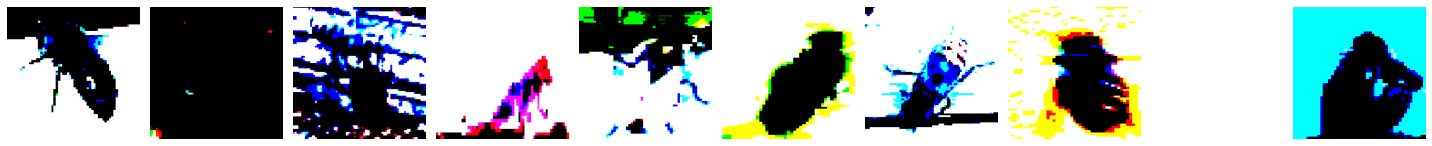

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [9]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [10]:
# Building the classifier/model
model = Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'), 
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Flatten(),
                    Dense(units=6, activation='softmax'),
])

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
357/357 - 40s - loss: 7.2296 - accuracy: 0.8194 - val_loss: 3.2077 - val_accuracy: 0.7585
Epoch 2/10
357/357 - 7s - loss: 0.3894 - accuracy: 0.9470 - val_loss: 2.3945 - val_accuracy: 0.8335
Epoch 3/10
357/357 - 7s - loss: 0.0927 - accuracy: 0.9792 - val_loss: 1.5703 - val_accuracy: 0.8900
Epoch 4/10
357/357 - 7s - loss: 0.0773 - accuracy: 0.9829 - val_loss: 2.1609 - val_accuracy: 0.7692
Epoch 5/10
357/357 - 7s - loss: 0.0588 - accuracy: 0.9837 - val_loss: 1.9503 - val_accuracy: 0.8277
Epoch 6/10
357/357 - 7s - loss: 0.0287 - accuracy: 0.9916 - val_loss: 2.9086 - val_accuracy: 0.7916
Epoch 7/10
357/357 - 7s - loss: 0.0183 - accuracy: 0.9958 - val_loss: 1.6321 - val_accuracy: 0.8277
Epoch 8/10
357/357 - 7s - loss: 0.0038 - accuracy: 0.9980 - val_loss: 1.5824 - val_accuracy: 0.8335
Epoch 9/10
357/357 - 7s - loss: 8.3832e-04 - accuracy: 0.9997 - val_loss: 1.5297 - val_accuracy: 0.8403
Epoch 10/10
357/357 - 7s - loss: 1.3060e-04 - accuracy: 1.0000 - val_loss: 1.5177 - val_accurac

In [13]:
predictions = model.predict(x=test_batches, verbose=0).argmax(axis=1)

In [14]:
np.round(predictions)

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 1, 5, 1, 5, 1, 5, 1, 2, 1, 5,
       1, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5,
       1, 5, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1,
       1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.figure(figsize=(7,7)) # to increase figure(confusion matrix) size

  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title=(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=70)
  plt.yticks(tick_marks,classes)
  thresh = cm.max() / 2.


  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

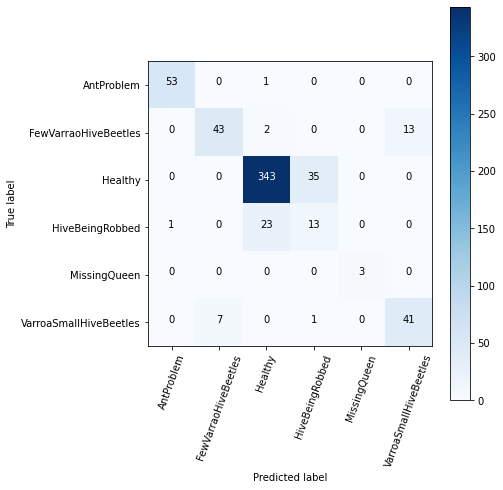

In [16]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=(predictions))
# print(cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=cm_plot_labels)
# disp.plot()
plot_confusion_matrix(cm, label_lst)

## Calculating the Precision, Recall, Accuracy, and the F1-Score

In [61]:
rpt = classification_report(y_true=test_batches.classes,y_pred=(predictions), target_names=label_lst)
print(rpt)

                        precision    recall  f1-score   support

            AntProblem       0.98      0.98      0.98        54
  FewVarraoHiveBeetles       0.86      0.74      0.80        58
               Healthy       0.93      0.91      0.92       378
       HiveBeingRobbed       0.27      0.35      0.30        37
          MissingQueen       1.00      1.00      1.00         3
VarroaSmallHiveBeetles       0.76      0.84      0.80        49

              accuracy                           0.86       579
             macro avg       0.80      0.80      0.80       579
          weighted avg       0.87      0.86      0.86       579



# One-vs-the-rest (OvR) multiclass strategy for ROC and AUC

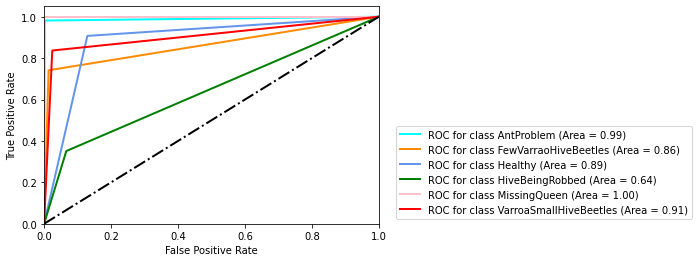

In [72]:
# Compute ROC curve and ROC area for each class
y_score = label_binarize(predictions, classes = [0, 1, 2, 3, 4, 5])
y_test = label_binarize(test_batches.classes, classes = [0, 1, 2, 3, 4, 5])
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_lst)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(1)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'pink', 'red'])
for i, color in zip(range(len(label_lst)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC for class {0} (Area = {1:0.2f})'
             ''.format(label_lst[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k-.', lw=lw, )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.95, 0))
plt.show()